In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
#%pylab inline

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.preprocessing import scale,MinMaxScaler

from sklearn import model_selection

from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV



In [3]:
# read train dataset
sampledata=pd.read_csv('/Users/tutongbi/Desktop/kaggle/Titantic/train.csv',delimiter=',')
#print(sampledata.describe())
# sampledata.info()

In [4]:
sampledata.isnull().sum()
sampledata.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [7]:
sampledata['Names'] = sampledata['Name'].map(lambda x: len(re.split(' ', x)))
    
# what is each person's title? 
sampledata['Title'] = sampledata['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
    
# group low-occuring, related titles together
sampledata['Title'][sampledata.Title == 'Jonkheer'] = 'Master'
sampledata['Title'][sampledata.Title.isin(['Ms','Mlle'])] = 'Miss'
sampledata['Title'][sampledata.Title == 'Mme'] = 'Mrs'
sampledata['Title'][sampledata.Title.isin(['Capt', 'Don', 'Major', 'Col', 'Sir'])] = 'Sir'
sampledata['Title'][sampledata.Title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'

/Users/tutongbi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tutongbi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tutongbi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tutongbi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to

In [8]:
sampledata['Age'].fillna(sampledata['Age'].mode()[0],inplace=True)
sampledata['Cabin'].fillna(sampledata['Cabin'].mode()[0],inplace=True)
sampledata['Embarked'].fillna(sampledata['Embarked'].mode()[0],inplace=True)

sampledata.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Names          0
Title          0
dtype: int64

In [9]:
sampledata['Embarked']=pd.factorize(sampledata['Embarked'])[0]
sampledata['Cabin']=pd.factorize(sampledata['Cabin'])[0]
sampledata['Sex']=pd.factorize(sampledata['Sex'])[0]

sampledata['Title']=pd.factorize(sampledata['Title'])[0]

#sampledata[['Age','Fare']]=scale(sampledata[['Age','Fare']])
scaler=MinMaxScaler()
sampledata[['Age','Fare']]=scaler.fit_transform(sampledata[['Age','Fare']])

sampledata.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Names,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,0.271174,1,0,A/5 21171,0.014151,0,0,4,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.472229,1,0,PC 17599,0.139136,1,1,7,1
2,3,1,3,"Heikkinen, Miss. Laina",1,0.321438,0,0,STON/O2. 3101282,0.015469,0,0,3,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.434531,1,0,113803,0.103644,2,0,7,1
4,5,0,3,"Allen, Mr. William Henry",0,0.434531,0,0,373450,0.015713,0,0,4,0
5,6,0,3,"Moran, Mr. James",0,0.296306,0,0,330877,0.016510,0,2,3,0


In [15]:
def RFmodel(X,y,seed=23):
    """
    This function is used to train the Random Forest model.
    It returns the range of numbers of parameters in X (xs) and their corresponding training errors (error1).
    It also outputs the number of parameters used in the best-fit RF model.
    """
    max_features2=X.shape[1]
    max_features1=1
    error1=[]
    clf1=RandomForestClassifier(oob_score=True,n_jobs=3,max_features=None,random_state=seed)
    for i in range(max_features1,max_features2+1):
        clf1.set_params(max_features=i)
        clf1.fit(X_train,y_train)
    
        oob_err=1-clf1.oob_score_
        error1.append((oob_err))
    best_rf=np.argmin(error1)+1
    xs=range(max_features1,max_features2+1)
    return xs,error1,best_rf,clf1

In [16]:
# iloc (selecting data by row numbers)
# loc (seclecting data by label or a conditional statement)
#x1=np.array(sampledata.iloc[:,(sampledata.columns!='Survived')&(sampledata.columns!='Age')])
#x1=np.array(sampledata.loc[:,sampledata.columns!='Survived'])


X=np.array(sampledata.iloc[:,[2,4,5,6,7,9,10,11,-1]])
#X = np.array(sampledata.iloc[:,(sampledata.columns!='Survived')&(sampledata.columns!='Name')])
#y = np.array(sampledata.iloc[:,1])
y = np.array(sampledata.iloc[:,sampledata.columns=='Survived'])
y = y.reshape(len(y),)

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

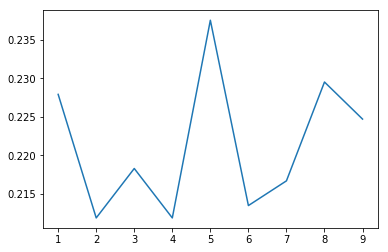

In [18]:
xs1,error2,best_rf1,clf1=RFmodel(X_train,y_train)
plt.plot(xs1,error2)
plt.show()

In [19]:
# train the model
clf1.set_params(max_features=best_rf1)
clf1.fit(X_train,y_train)

# test the model performance
prob1 =clf1.predict_proba(X_test) # save the probability for SVM
y_pred1=prob1[:,1]
preci1,rec1,thre1=precision_recall_curve(y_test,y_pred1) # PR curve information
fpr1,tpr1,threshold1=roc_curve(y_test,y_pred1)# ROC curve information

In [20]:
print('feature importance:',clf1.feature_importances_)
print('The mean accuracy on the train dataset:',clf1.score(X_train,y_train))
print('The mean accuracy on the test dataset:',clf1.score(X_test,y_test))

('feature importance:', array([ 0.06971177,  0.14547817,  0.21972887,  0.06133812,  0.03175491,
        0.21139563,  0.06520781,  0.03503784,  0.16034686]))
('The mean accuracy on the train dataset:', 0.9759229534510433)
('The mean accuracy on the test dataset:', 0.84701492537313428)


In [ ]:
### linear SVM
seed=23
C_range=np.logspace(-2,2,10)
#gamma_range=np.logspace(-3,3,7)
svrl=SVC(kernel='linear')
cv=KFold(n_splits=5,random_state=seed)
param_grid=dict(C=C_range)
clf2=GridSearchCV(svrl,param_grid,cv=cv,njobs=3,verbose=1)
clf2.fit(X_train,y_train)

C=clf2.best_params_['C']
#gamma=clf2.best_params_['gamma']

#clf2= SVC(kernel = 'linear', C = C,gamma=gamma, probability = True)
clf2= SVC(kernel = 'linear', C = C,probability = True)
clf2.fit(X_train,y_train)